## What makes a good Random Forest Classifier Column

By Lois Keller Smith, July 2017


AKA Learning to speak machine

When I was first learning how to work with Random Forests, I thought throwing everything at them, ranking the features, and then removing bad features was the way to build a good model. Well, that was true... it will build a 'good' model, but if you want a great model, you need to be smart about your features.

This is a quick demo on just how trying to speak more along the lines of Random Forest (RF) Classifier will obtain better results. In looking to split things, RF Classifiers prefer data columns that also split cleanly. 

### The problem

You're trying to identify how likely citizens of Taxiville will get picked up within 5 minutes of calling a taxi. Of course, the center of Taxiville, at Latitude 42, Longitude 144, is a taxi dispatch center! How convenient! 

Your hypotheiss is that the closer you are to Taxiville's center, the more likely you'll be picked up in 5 minutes. Your boss asks you to build a model that accounts for this based on 50,000 previous taxi pickups (we make up the data, but assume it's real!). 

We're going to build a Random Forest Classifier that is, honestly, a terrible model because we only have latitude/longitude information. But let's see if we can make it better.. 



In [320]:
# First, import some modules we'll need for this exericse. Make sure you have matplotlib, numpy, pandas, and sklearn 
# installed prior 
# standard imports 
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt


We will start by generating our own data. You're welcome to play around with this, but they 'key' feature is that the probability of getting picked up within 5 minutes is an exponential distance function of radial distance away from Taxiville center. So the farther away you are, the less likely you will be picked up in 5 minutes. When you're building your model in real life, however, you wouldn't know this ;) 

In [322]:
# generate random data
# we know the city center at 42.0 degrees latitude and 144.0 degrees longitude. This is where 'the most' traffic occurs
# the city bounds are at 41.9 degrees and 42.2 degrees latitude and 
# 143.8 degrees and 144.1 degrees longitude 
# thus, a taxi cab is most likely to pick up here 

# create random data list
lats=[random.uniform(41, 43) for i in range(50000)]
lons=[random.uniform(143, 145) for i in range(50000)]


We are going to engineer our own feature. Since latitude and longitude vary both positively and negatively around the center point, it isn't a linearly increasing variable (+0.1 and -0.1 latitude are the same distance away). Linearly increasing or decreasing variables are the easier for RF Classifiers to split on (look up the Gini Importance if you want to know more about how RF models make their splits: https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#giniimp

In [324]:
# get the radial distance - using a^2 + b^2 = c^2  
r = [np.sqrt((lats[i] - 42.0)**2  + (lons[i] - 144.0)**2) for i in range(50000)]
r2=np.array(r)

# taxi pick up time is based on probability determined by exponential decay with radial distance 
# we use probabilities in order to add some variability to the data, making it more challenging for our model 
# to succeed
taxiResult= [ np.random.choice([0,1], p=[1.- np.exp(-1.0*(2*r2[j])),np.exp(-1.0*(2*r2[j]))]) for j in range(50000)]
tR=np.array(taxiResult)
print('number of taxis within 5 minutes: '+str(len(tR[tR==1])))
print('number of taxis not within 5 mintues: '+str(len(tR[tR==0])))

# now turn into a data frame for modeling 
df=pd.DataFrame({'Lat':lats, 'Lon':lons, 'R':r, 'TaxiResult':taxiResult})
df.head(10)


number of taxis within 5 minutes: 12800
number of taxis not within 5 mintues: 37200


,Lat,Lon,R,TaxiResult
0,41.814408,144.568227,0.597768,1
1,41.757670,144.918665,0.950089,0
2,41.729716,143.072913,0.965683,0
3,41.289311,143.747219,0.754306,1
4,41.482865,144.901304,1.039124,0
5,42.098892,144.657687,0.665081,0
6,42.451064,143.377503,0.768740,1
7,42.589309,143.040082,1.126378,0
8,41.039276,144.067610,0.963100,0
9,41.798062,143.240443,0.785942,0


We want to add ONE more feature - we're going to make a yes/no feature called closeness. We we run the script below, we see that even though 'picked up' (blue) is common below a radial distance of 1.3, many 'not picked up's (green) exist in this range too. We find that at approximately r < 0.3 we're more likely to be picked up than not, so we choose that too define closeness. 

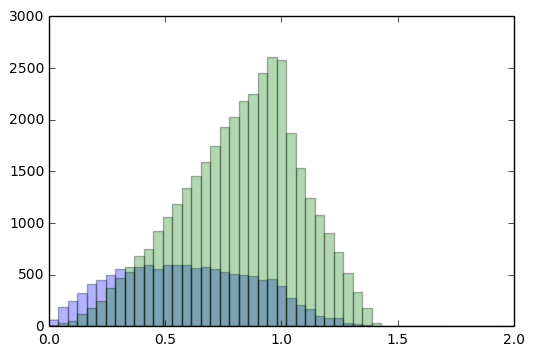

In [325]:
%matplotlib inline

# we are going to create a closeness variable to predict with 
closeness=np.zeros(50000)

# first, we need to figure out where our probability of getting picked up within 5 minutes is highest. 
# we are going to overplot the 'yes' (picked up) as blue and the 'no' (not picked up) as green. 
fig=plt.figure()
plt.hist(r2[tR==1], bins=np.linspace(0, 2, 50), alpha=0.3, color='blue')
plt.hist(r2[tR==0], bins=np.linspace(0, 2, 50), alpha=0.3, color='green')
fig=plt.figure()
plt.show()

closeness[r2<0.3]=1
closeness[r2>=0.3]=0
df['closeness']=closeness
cdf=r2[tR==1]


Let's see which one does best in the Random Forest Classifier!

In [326]:
# great now apply random forest classifier
train, test = train_test_split(df, test_size = 0.25,random_state=2)
#
# test success of models using different features
features_ll=['Lat', 'Lon']
features_r=['R']
features_cn=['closeness']

# set up the classifier, no special features here 
clf_ll=RandomForestClassifier()
clf_r=RandomForestClassifier()
clf_cn=RandomForestClassifier()

# train the model 
clf_ll.fit(train[features_ll], train['TaxiResult'])
clf_r.fit(train[features_r], train['TaxiResult'])
clf_cn.fit(train[features_cn], train['TaxiResult'])

# make a prediction
predict_ll=clf_ll.predict(test[features_ll])
predict_r=clf_r.predict(test[features_r])
predict_cn=clf_cn.predict(test[features_cn])

# score with r^2, it's going to be ugly here 
r2_ll=metrics.r2_score(test['TaxiResult'], predict_ll)
r2_r=metrics.r2_score(test['TaxiResult'], predict_r)
r2_cn=metrics.r2_score(test['TaxiResult'], predict_cn)

# score with confusion matrix. From top row across, it goes true positive, false positive, 
# false negative, true negative
c_ll=metrics.confusion_matrix(test['TaxiResult'], predict_ll)
c_r=metrics.confusion_matrix(test['TaxiResult'], predict_r)
c_cn=metrics.confusion_matrix(test['TaxiResult'], predict_cn)


print('r2 for Lat/Lon: '+str(r2_ll))
print('r2 for R: '+str(r2_r))
print('r2 for Closeness: '+str(r2_cn))

print('Confusion Matrix for Lat/Lon: '+str(c_ll))
print('Confusion Matrix for R: '+str(c_r))
print('Confusion Matrix for Closeness: '+str(c_cn))

# print out the accuracy (how many successful hits)
print('Accuracy Score for Lat/Lon: '+ str(metrics.accuracy_score(test['TaxiResult'], predict_ll)))
print('Accuracy Score for R: '+ str(metrics.accuracy_score(test['TaxiResult'], predict_r)))
print('Accuracy Score for Closeness: '+ str(metrics.accuracy_score(test['TaxiResult'], predict_cn)))                                        
                            

r2 for Lat/Lon: -0.398422928542
r2 for R: -0.642558662161
r2 for Closeness: -0.22277966408
Confusion Matrix for Lat/Lon: [[8366  936]
 [2392  806]]
Confusion Matrix for R: [[7524 1778]
 [2131 1067]]
Confusion Matrix for Closeness: [[9016  286]
 [2624  574]]
Accuracy Score for Lat/Lon: 0.73376
Accuracy Score for R: 0.68728
Accuracy Score for Closeness: 0.7672


### Result: Closeness is best for accuracy followed by Lat/Lon and then radial distance

Explanation:

(1) Being frank, Random Forest is probably not the best way to go for a probability based model. Check out Naive Bayes. 

(2) Lat/Lon performed better than radial distance (R) even though we know the model is directly based on R. Why? Some of this is because more columns help a RF model make splits. More features usually is a good thing in a Random Forest model, especially if the features are adding more information (which they are here). This model might be even stronger if certain lat/lon combinations are prone to high traffic points. 

(3) Because we looked at the data and made a smart decision about how to feed the RF Classifier information, it handled 'Closeness' the best. Think about your features!! 

Note: the accuracy for this model is pretty bad. But considering it's only based on 1-2 features, we're doing OK. 

See if you can engineer this problem further or play around by adding time stamps and a rush hour!